In [ ]:
##Modèle : vgg16+SVM :pour trouver 8 classes de cellules saines 
##Data:  df_vgg16_svm_8_filt.pkl :  comprend les données 

In [1]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET
import sklearn
import itertools
import scipy
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from matplotlib import cm # To import new color cards
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pathlib

In [2]:

TT=pathlib.Path("__file__").parent.resolve()
path_L=str(TT).replace("\\","/") 
P=pathlib.PureWindowsPath(path_L)
path_L=str(P.parents[0])+"/pkl_files/" 

filename = path_L+'df_vgg16_svm_8_filt.pkl'

df= pickle.load(open(filename, 'rb'))
df['out']=df.label
print(df.out.unique())




['basophil' 'erythroblast' 'eosinophil' 'lymphocyte' 'ig' 'monocyte'
 'neutrophil' 'platelet']


In [3]:
path_new=str(P.parents[0])+'\\data\\'

path_new=str(path_new).replace("\\","/") 


In [4]:
df["path"]=df["path"].str.replace("C:/Users/laleh/Documents/Ml_logiciel/Datascientest/Data_Mendely_Segment5/",path_new+"Data_Mendeley_filt/")
df["path"]=df["path"].str.replace("C:/Users/laleh/Documents/Ml_logiciel/Datascientest/Data_AML_Segment/",path_new+"Data_AML_filt/")
df["path"]=df["path"].str.replace("C:/Users/laleh/Documents/Ml_logiciel/Datascientest/Data_Raabin_Segment/",path_new+"Data_Raabin_filt/")


print(df["path"].unique())
                                 

['C:/Users/laleh/Documents/Pythons/projet_blood/vgg16_svm/data/Data_AML_filt/BAS/BAS_0001.tiff'
 'C:/Users/laleh/Documents/Pythons/projet_blood/vgg16_svm/data/Data_AML_filt/BAS/BAS_0002.tiff'
 'C:/Users/laleh/Documents/Pythons/projet_blood/vgg16_svm/data/Data_AML_filt/BAS/BAS_0004.tiff'
 ...
 'C:/Users/laleh/Documents/Pythons/projet_blood/vgg16_svm/data/Data_Mendeley_filt/platelet/PLATELET_999701.jpg'
 'C:/Users/laleh/Documents/Pythons/projet_blood/vgg16_svm/data/Data_Mendeley_filt/platelet/PLATELET_999873.jpg'
 'C:/Users/laleh/Documents/Pythons/projet_blood/vgg16_svm/data/Data_Mendeley_filt/platelet/PLATELET_999931.jpg']


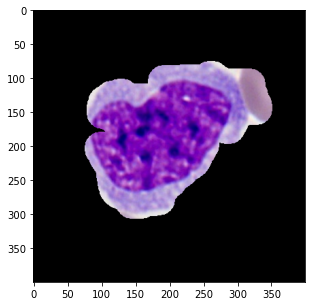

In [6]:
fig = plt.figure(figsize = (5,5))

df3_pla=df[(df.label=='monocyte')]

j=np.random.randint(0,len(df3_pla))
img_path=df3_pla.path.iloc[j]
 
plt.imshow(plt.imread(img_path))

In [4]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=123)



In [5]:
print(len(list(data_train.out.unique())))
print(len(list(data_test.out.unique())))
print(len(df))

8
8
28065


In [6]:


train_data_generator=ImageDataGenerator(
preprocessing_function=preprocess_input,
rotation_range=10,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=1.1,
    
horizontal_flip=True)

test_data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 32


train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col='out',
                                                           class_mode ="sparse",
                                                           #color_mode= "grayscale",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "path",
                                                           y_col='out',
                                                           class_mode ="sparse",
                                                         #color_mode= "grayscale",
                                                          target_size = (224 , 224), 
                                                          batch_size = batch_size)

Found 22452 validated image filenames belonging to 8 classes.
Found 5613 validated image filenames belonging to 8 classes.


In [7]:
from PIL import Image

def convert_image(X):
    X_img=[]
    for image in X:
        
        
             with Image.open(image) as im:

    
                    img = im.resize((224, 224))
                 
                    
                    a = np.asarray(img)
                    #print(a.shape)
                    if a.shape[2]==4:  #si c'est un fichier tiff
                       
                        im = im.convert("RGB")
                        img = im.resize((224, 224))
                        a = np.asarray(img)
             
                    
                    
                    
                    X_img.append(a) 
                    
                    
    return np.array(X_img)

# Load the images train
X_train_img= convert_image(data_train.path)
Y_train = data_train['out']

# Load the images test
X_test_img = convert_image(data_test.path)
Y_test = data_test['out']


# Modèle 

In [8]:
n_class=8


base_model=VGG16(weights='imagenet', include_top=False) #, input_tensor=img_conc)
for layer in base_model.layers:
    layer.trainable=False
    
    
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(n_class, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(generator=train_generator, 
                                epochs = 10,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(data_test)//batch_size
                                )
for layer in base_model.layers[-4:]:
  layer.trainable = True
    
    
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#base_model.summary()

C:\Users\laleh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
701/701 [==============================] - 257s 348ms/step - loss: 1.1364 - acc: 0.6178 - val_loss: 0.7846 - val_acc: 0.7248
Epoch 2/10
701/701 [==============================] - 248s 354ms/step - loss: 0.8678 - acc: 0.6992 - val_loss: 0.6229 - val_acc: 0.7823
Epoch 3/10
701/701 [==============================] - 243s 346ms/step - loss: 0.8120 - acc: 0.7150 - val_loss: 0.5493 - val_acc: 0.8057
Epoch 4/10
701/701 [==============================] - 240s 342ms/step - loss: 0.7721 - acc: 0.7302 - val_loss: 0.6770 - val_acc: 0.7721
Epoch 5/10
701/701 [==============================] - 239s 341ms/step - loss: 0.7474 - acc: 0.7371 - val_loss: 0.5571 - val_acc: 0.8073
Epoch 6/10
701/701 [==============================] - 239s 340ms/step - loss: 0.7348 - acc: 0.7456 - val_loss: 0.5690 - val_acc: 0.7986
Epoch 7/10
701/701 [==============================] - 240s 342ms/step - loss: 0.7169 - acc: 0.7520 - val_loss: 0.6270 - val_acc: 0.7843
Epoch 8/10
701/701 [============================

C:\Users\laleh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:



history = model.fit_generator(generator=train_generator, 
                                epochs = 30,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data=test_generator,
                                validation_steps=len(data_test)//batch_size
                                )


intermediate_layer_model =Model( inputs=model.input, outputs=model.layers[2].output)
X_train_features = intermediate_layer_model.predict(preprocess_input(X_train_img))
X_test_features = intermediate_layer_model.predict(preprocess_input(X_test_img))

svm = SVC(C=111)
params = {'C':np.linspace(0.1, 1000, 10) }


grid = GridSearchCV(estimator=svm, param_grid=params, cv=3)
grid = grid.fit(X_train_features,  data_train["out"])
print(grid.best_params_)
print(grid.score(X_test_features,data_test["out"]))

#grid = svm.fit(X_train_features,  data_train["out"])

Epoch 1/30
701/701 [==============================] - 245s 342ms/step - loss: 0.7632 - accuracy: 0.7422 - val_loss: 0.2936 - val_accuracy: 0.9016
Epoch 2/30
701/701 [==============================] - 244s 348ms/step - loss: 0.5304 - accuracy: 0.8211 - val_loss: 0.2518 - val_accuracy: 0.9186
Epoch 3/30
701/701 [==============================] - 239s 341ms/step - loss: 0.4624 - accuracy: 0.8407 - val_loss: 0.2247 - val_accuracy: 0.9225
Epoch 4/30
701/701 [==============================] - 242s 345ms/step - loss: 0.4254 - accuracy: 0.8576 - val_loss: 0.1929 - val_accuracy: 0.9436
Epoch 5/30
701/701 [==============================] - 242s 345ms/step - loss: 0.3949 - accuracy: 0.8653 - val_loss: 0.2268 - val_accuracy: 0.9259
Epoch 6/30
701/701 [==============================] - 241s 344ms/step - loss: 0.3736 - accuracy: 0.8719 - val_loss: 0.2605 - val_accuracy: 0.9087
Epoch 7/30
701/701 [==============================] - 241s 344ms/step - loss: 0.3658 - accuracy: 0.8758 - val_loss: 0.2803 -

In [10]:
print(df.label.unique())

['basophil' 'erythroblast' 'eosinophil' 'lymphocyte' 'ig' 'monocyte'
 'neutrophil' 'platelet']


In [11]:

classes_names=["neutrophil","eosinophil","ig","platelet","erythroblast","monocyte","basophil","lymphocyte"]

Y_test=Y_test.replace(["neutrophil","eosinophil","ig","platelet","erythroblast",
                            "monocyte","basophil","lymphocyte"],[0,1,2,3,4,5,6,7])

data_train['out']=data_train['out'].astype(str)
predictions_svm = grid.predict(X_test_features)
predictions_svm=np.where(predictions_svm=="neutrophil",0, predictions_svm)
predictions_svm=np.where(predictions_svm=="eosinophil",1, predictions_svm) 
predictions_svm=np.where(predictions_svm=="ig",2, predictions_svm) 
predictions_svm=np.where(predictions_svm=="platelet",3, predictions_svm) 
predictions_svm=np.where(predictions_svm=="erythroblast",4, predictions_svm) 
predictions_svm=np.where(predictions_svm=="monocyte",5, predictions_svm)
predictions_svm=np.where(predictions_svm=="basophil",6, predictions_svm)
predictions_svm=np.where(predictions_svm=="lymphocyte",7, predictions_svm)



from sklearn.metrics import classification_report
print(classification_report(Y_test.values.astype(int),
predictions_svm.astype(int), target_names=classes_names))

C:\Users\laleh\AppData\Local\Temp/ipykernel_10420/507296964.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['out']=data_train['out'].astype(str)


              precision    recall  f1-score   support

  neutrophil       0.98      0.98      0.98      1702
  eosinophil       0.98      0.97      0.98       734
          ig       0.90      0.94      0.92       489
    platelet       0.99      0.99      0.99       509
erythroblast       0.98      0.96      0.97       291
    monocyte       0.93      0.92      0.93       514
    basophil       0.96      0.97      0.97       267
  lymphocyte       0.97      0.96      0.96      1107

    accuracy                           0.97      5613
   macro avg       0.96      0.96      0.96      5613
weighted avg       0.97      0.97      0.97      5613



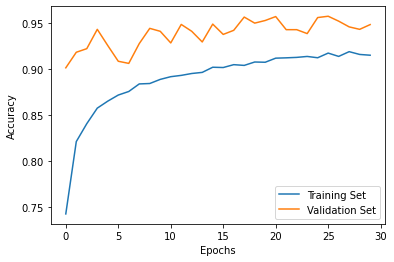

In [12]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure()
plt.plot(np.arange(len(training_accuracy)), training_accuracy, label = 'Training Set')
plt.plot(np.arange(len(training_accuracy)), validation_accuracy, label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [13]:
filename = 'svm_MTL_Segment_8classes_T.pkl'
pickle.dump(grid, open(filename, 'wb'))

#grid= pickle.load(open(filename, 'rb'))

In [14]:
from tensorflow.keras.models import save_model, load_model
save_model(model,"MTL_MTL_Segment_8classes_T")
#del model
#model=load_model("MTL_MTL_Segment_8classes_T")

INFO:tensorflow:Assets written to: MTL_MTL_Segment_8classes_T\assets


In [15]:
img_height, img_width=224,224
model1=base_model

########################################################################### Grad-CAM Functions

import matplotlib.cm as cm

def get_img_array(img_path, size = (img_height, img_width)):

  img = tf.keras.preprocessing.image.load_img(img_path, target_size = size)
  array = tf.keras.preprocessing.image.img_to_array(img)
  array = np.expand_dims(array, axis = 0)
  return array

def make_heatmap(img_array, model1, last_conv_layer, class_index):

  grad_model = tf.keras.models.Model([model1.inputs], [last_conv_layer.output, model1.output])
  
  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
 
    class_channel = preds[:, class_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))

  heatmap_tmp = last_conv_layer_output[0].numpy()

  for i in range(512):
    heatmap_tmp[:,:,i] *= pooled_grads[i]
  heatmap = np.mean(heatmap_tmp, axis=-1)
  return heatmap

def gradcam(model1, img_path, class_index = None, alpha = 0.5, plot = True):

  # Détecte la dernière couche de convolution (pas terrible : il faudrait sélectionner sur le type, pas sur le nom) :
  for layer in reversed(model1.layers):                ################
    if 'conv' in layer.name:
      last_conv_layer = model1.get_layer(layer.name)
      break

  # Chargement + mise en forme de l'image :
  img_array = get_img_array(img_path, size = (img_height, img_width))
  """
  # Choix de la classe à représenter :
  if class_index == None :
    # Désactiver Sotfmax sur la couche de sortie :
    model1.layers[-1].activation = None
    # Prédiction + classe la plus probable :
    predict = model1.predict(img_array)
    class_index = np.argmax(predict[0])
 """
  # Calcul de la CAM : resize pour comparaison avec l'image finale
  
  heatmap = make_heatmap(img_array, model1, last_conv_layer, class_index)
  big_heatmap = heatmap
  #big_heatmap = cv2.resize(heatmap, dsize = (img_height, img_width), interpolation = cv2.INTER_CUBIC)

  ## Traitement de la Heatmap
  # 1/ Normalisation
  big_heatmap = big_heatmap/big_heatmap.max()
  # 2/ On passe dans ReLu, pour flinguer les valeurs négatives
  big_heatmap = np.maximum(0, big_heatmap)
  
  ## Superposition de l'image et de la Heatmap 
  # 1/ Import de l'image d'origine
  img = tf.keras.preprocessing.image.load_img(img_path)
  img = tf.keras.preprocessing.image.img_to_array(img)

  # 2/ Rescale heatmap: 0-255
  big_heatmap = np.uint8(255*big_heatmap)

  # 3/ Jet colormap
  jet = cm.get_cmap("jet")

  # 4/ Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[big_heatmap]
  
  # 5/ Create an image with RGB colorized heatmap
  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

  # 6/ Superimpose the heatmap on original image
  superimposed_img = jet_heatmap*alpha + img
  superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

  if plot == True:
    # 7/ Affichage des résultats
    fig = plt.figure(figsize = (8,8))
    fig.add_subplot(1,2,1)
    plt.imshow(big_heatmap)

    fig.add_subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Chosen class : "+str(list(label_map.keys())[class_index]))
  return big_heatmap, superimposed_img

In [16]:
y_pred = predictions_svm
classes_names=['basophil' ,'erythroblast','eosinophil', 'lymphocyte' ,'ig' ,'monocyte', 'neutrophil' ,'platelet']

# DF avec le résultat et le label de toutes les images du test :
df_results = pd.DataFrame(data = {"real":Y_test.values.astype(int),
                                  "pred":y_pred.astype(int), 
                                  "img_path":data_test["path"],
                                 "label": data_test["label"]})

# Tri des images : mal classé (df_false), bien classé (df_true):
df_false = df_results[df_results["real"] != df_results["pred"]].reset_index(drop = True)
df_true = df_results[df_results["real"] == df_results["pred"]].reset_index(drop = True)


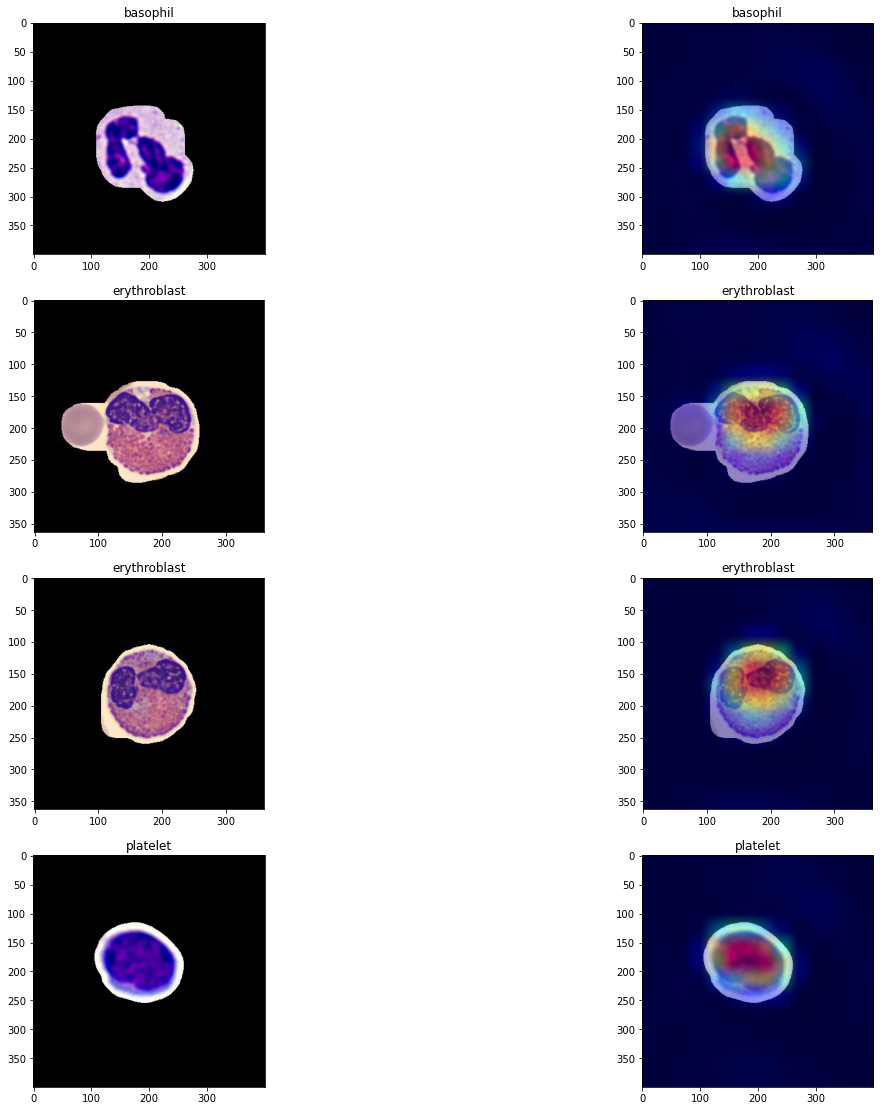

In [17]:
fig = plt.figure(figsize = (20, 40))
i = 0

for j in np.random.randint(0,len(df_true),4):
  
 
  img_path = df_true.loc[j,"img_path"]
 
  big_heatmap, superimposed_img = gradcam(base_model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(8,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(classes_names[df_true.loc[j,"real"]])

  fig.add_subplot(8,2,i+2)
  plt.imshow(superimposed_img)
  plt.title(classes_names[df_true.loc[j,"pred"]])
  i += 2

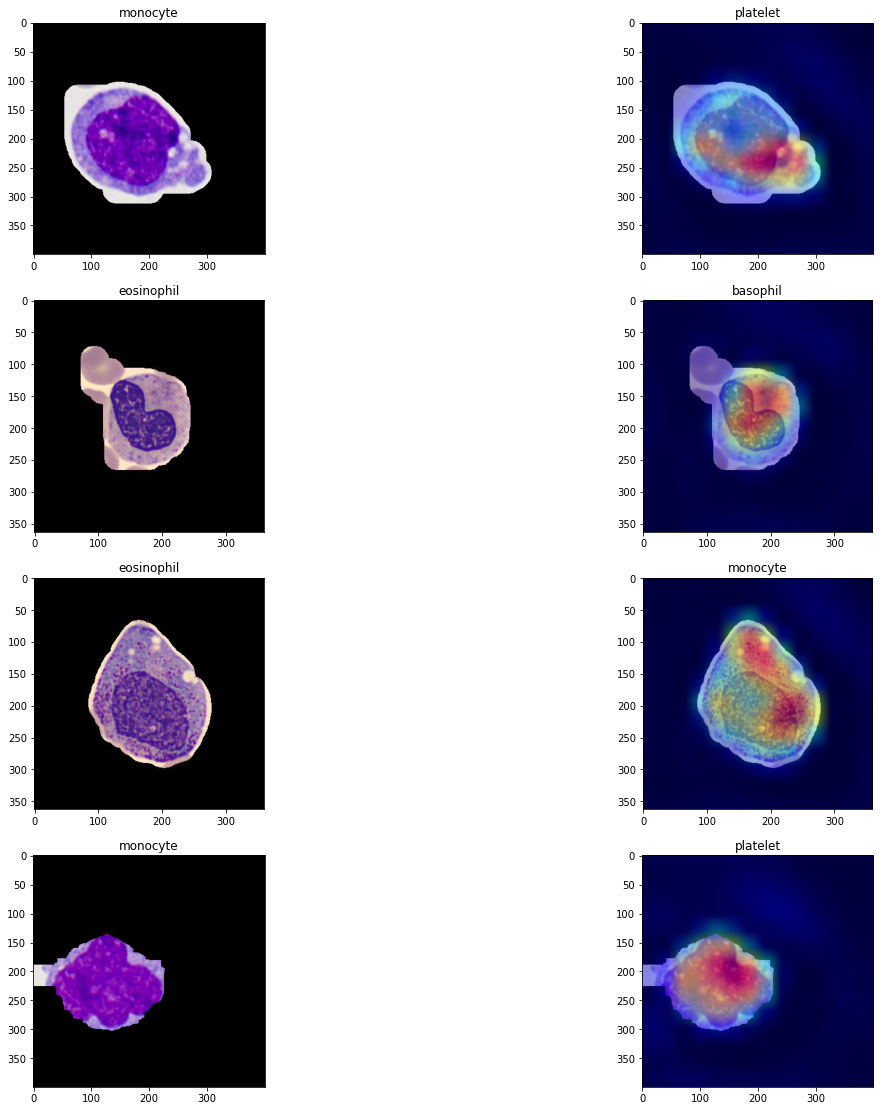

In [18]:
fig = plt.figure(figsize = (20, 40))
i = 0

for j in np.random.randint(0,len(df_false),4):
  
 
  img_path = df_false.loc[j,"img_path"]
 
  big_heatmap, superimposed_img = gradcam(base_model, img_path, alpha = 0.8, plot = False)

  fig.add_subplot(8,2,i+1)
  plt.imshow(plt.imread(img_path))
  plt.title(classes_names[df_false.loc[j,"real"]])

  fig.add_subplot(8,2,i+2)
  plt.imshow(superimposed_img)
  plt.title(classes_names[df_false.loc[j,"pred"]])
  i += 2